In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
sys.path.append('..')
from utils.data import Subject, Block

In [3]:
sample_dir = "/Users/hugofluhr/phd_local/data/LearningHabits/data-samples"
behav_dir = os.path.join(sample_dir, "behav")

In [4]:
raw_data = sio.loadmat(os.path.join(behav_dir, "habit_c07g3u_2_2024-04-30_10-35.mat"), squeeze_me=True, struct_as_record=False)

In [5]:
sub = Subject(os.path.join(behav_dir, "habit_c07g3u_2_2024-04-30_10-35.mat"))

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:108: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")
/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_trials = pd.concat(all_trials, ignore_index=True)


In [6]:
sub.learning_phase[0].trials

,left_stim,right_stim,left_value,right_value,shift,action,rt,chosen_stim,reward,correct,t_first_stim,t_second_stim,t_action,t_purple_frame,t_points_feedback,t_iti_onset,t_trial_end
0,2,1,2,1,0,1.0,0.682432,2.0,2,1.0,0.008866,0.976454,1.658886,1.677057,2.194229,3.528797,9.884760
1,1,3,1,2,0,2.0,0.487746,3.0,2,1.0,9.884760,10.752116,11.239862,11.252611,11.769698,13.287803,20.578003
2,6,8,4,5,0,1.0,0.465525,6.0,4,0.0,20.578003,21.445361,21.910886,21.912477,22.429603,23.981052,31.705002
3,8,7,5,4,0,2.0,0.474767,7.0,4,0.0,31.705002,32.689135,33.163902,33.172911,33.690086,35.224847,42.181272
4,2,4,2,3,0,1.0,0.790170,2.0,2,0.0,42.181272,43.048734,43.838904,43.849457,44.366741,45.584414,51.690178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,3,1,2,0,2.0,0.444529,3.0,2,1.0,923.364834,924.282175,924.726703,924.732618,925.249758,926.817866,933.457436
92,1,2,1,2,1,2.0,0.405896,2.0,2,1.0,933.457436,934.274806,934.680703,934.691850,935.208987,936.810478,944.567739
93,6,4,4,3,1,1.0,0.449171,6.0,4,1.0,944.567739,945.518543,945.967714,945.969004,946.486093,948.054205,954.093267
94,7,8,4,5,1,1.0,0.397754,7.0,4,0.0,954.093267,954.943935,955.341689,955.344308,955.861499,957.479624,963.518667


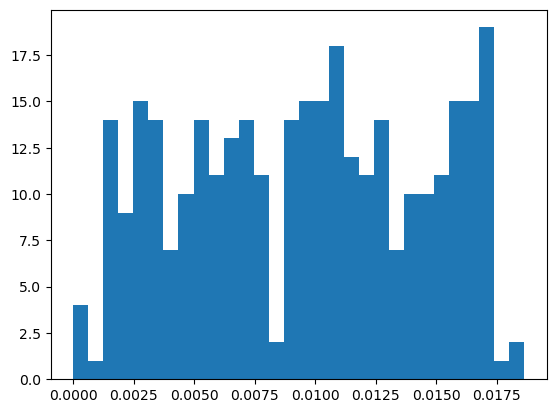

In [7]:
non_zero_values = sub.trials['t_purple_frame'] - sub.trials['t_action']
plt.hist(non_zero_values, bins=30);

## Events in a trial:
- first_stim_only
- both_stim_presentation
- response (key press)
- purple frame displayed with response
- points displayed
- iti

In [8]:
sub.trials.columns

Index(['block', 'left_stim', 'right_stim', 'left_value', 'right_value',
       'shift', 'action', 'rt', 'chosen_stim', 'reward', 'correct',
       't_first_stim', 't_second_stim', 't_action', 't_purple_frame',
       't_points_feedback', 't_iti_onset', 't_trial_end'],
      dtype='object')

In [9]:
def write_events_file(sub):
    '''
    Write an events file for the subject
    '''
    

In [14]:
sub.get_event_df('test')

,onset,duration,trial_type
0,0.002476,0.900746,first_stim_presentation
1,0.903222,0.618757,second_stim_presentation
2,1.521979,0.000000,response
3,1.537164,1.885091,purple_frame
4,3.422255,7.690451,iti
...,...,...,...
674,1363.983396,0.867410,first_stim_presentation
675,1364.850806,0.366302,second_stim_presentation
676,1365.217108,0.000000,response
677,1365.234459,2.135365,purple_frame
